# Predicting ICU type based on patient info

This code imports all the essential libraries required for the reserach question 2, encompassing data manipulation, model building, and evaluation. It establishes optimal display settings for analysis and prepares the environment for classification tasks utilizing both traditional algorithms and neural networks.

In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, ConfusionMatrixDisplay,
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve
from sklearn.impute import SimpleImputer
# Imbalanced learning
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline   # IMPORTANT: imblearn Pipeline

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

np.random.seed(42)

This code loads multiple healthcare datasets containing patient ICU outcomes, vital signs, lab results, and treatment records, which will be used to analyse and predict patient outcomes during intensive care.


In [ ]:
# LOAD DATASETS
pt_icu_outcome = pd.read_csv("pt_icu_outcome.csv")  # Patient ICU outcomes and targets
vitals = pd.read_csv("/content/vitals_hourly.csv")  # Hourly vital signs measurements
labs   = pd.read_csv("labs_hourly.csv")             # Hourly laboratory test results
gcs    = pd.read_csv("gcs_hourly.csv")              # Hourly Glasgow Coma Scale scores
patients   = pd.read_csv("patients.csv")            # Patient demographic information
admissions = pd.read_csv("admissions.csv")          # Hospital admission details
vaso  = pd.read_csv("vasopressors.csv")             # Vasopressor medication records
vent  = pd.read_csv("/content/pv_mechvent.csv")     # Mechanical ventilation data
abx   = pd.read_csv("antibiotics.csv")              # Antibiotic administration records

This code filters the dataset to include only adult patients with a valid ICU length of stay of at least one day, then randomly selects one ICU stay per hospital admission to avoid sampling bias. It then creates a binary outcome variable defining prolonged ICU stay (≥7 days) and extracts the list of eligible ICU stays for downstream analysis.

In [ ]:
# Adults, valid LOS, ICU stay >= 1 day
pt_icu = (
    pt_icu_outcome
    .query("age_years >= 18")
    .dropna(subset=["los"])
    .query("los >= 1")
    .copy()
)

# Randomly select ONE ICU stay per hospital admission
pt_icu["random_score"] = np.random.random(len(pt_icu))

cohort = (
    pt_icu
    .sort_values(["hadm_id", "random_score"])
    .drop_duplicates(subset="hadm_id", keep="first")
    .drop(columns="random_score")
    .copy()
)

# Create prolonged stay label
cohort["prolonged_stay"] = (cohort["los"] >= 7).astype(int)

eligible_ids = cohort["icustay_id"].unique()
print("Final cohort size:", len(cohort))


Final cohort size: 42496


This code extracts only the first 24 hours of clinical data (vitals, labs, and GCS) for the ICU stays included in the cohort. It filters each dataset to keep rows where the icustay_id is part of the selected cohort and where the recorded hour (hr) is ≤ 24.

In [ ]:
vitals_24h = vitals[(vitals.icustay_id.isin(eligible_ids)) & (vitals.hr <= 24)]
labs_24h   = labs[(labs.icustay_id.isin(eligible_ids))     & (labs.hr <= 24)]
gcs_24h    = gcs[(gcs.icustay_id.isin(eligible_ids))       & (gcs.hr <= 24)]



This code removes physiologically impossible values from the first 24-hour vitals and lab measurements to improve data quality.

In [ ]:
vitals_clean = vitals_24h[
    (vitals_24h['heartrate'].between(30, 220)) &
    (vitals_24h['meanarterialpressure'].between(30, 200)) &
    (vitals_24h['resprate'].between(5, 60)) &
    (vitals_24h['temperature'].between(26, 43)) &
    (vitals_24h['spo2'].between(50, 100))
]

labs_clean = labs_24h[
    (labs_24h['creatinine'].between(0.1, 25)) &
    (labs_24h['bloodureanitrogen'].between(1, 250)) &
    (labs_24h['whitebloodcell'].between(0.1, 300)) &
    (labs_24h['lactate'].between(0.2, 30)) &
    (labs_24h['bilirubin'].between(0.1, 50))
]

This code summarises each patient’s early clinical status by aggregating the first 24 hours of vital signs, laboratory values, and neurological assessments using clinically meaningful rule.

In [ ]:
vitals_summary = vitals_clean.groupby("icustay_id").agg({
    "heartrate": "mean",
    "meanarterialpressure": "min",
    "resprate": "max",
    "temperature": "min",
    "spo2": "min"
}).reset_index()

labs_summary = labs_clean.groupby("icustay_id").agg({
    "lactate": "max",
    "creatinine": "max",
    "whitebloodcell": "max",
    "bilirubin": "max",
    "bloodureanitrogen": "max"
}).reset_index()

gcs_summary = (
    gcs_24h.groupby("icustay_id")["gcs"]
    .min()
    .reset_index()
    .rename(columns={"gcs": "gcs_min"})
)


This code adds gender and admission characteristics to the final dataset.

In [ ]:
cohort = cohort.merge(
    patients[["subject_id", "gender"]], on="subject_id", how="left"
)
cohort = cohort.merge(
    admissions[["hadm_id", "admission_type"]], on="hadm_id", how="left"
)

final_df = (
    cohort
        .merge(vitals_summary, on="icustay_id", how="left")
        .merge(labs_summary,   on="icustay_id", how="left")
        .merge(gcs_summary,    on="icustay_id", how="left")
)


This code calculates the percentage of missing values for every variable in the final dataset. It then prints the 20 variables with the highest missingness.

In [ ]:
# Calculate and display missing data percentages to assess data quality
missing_values = final_df.isnull().mean() * 100
print("\nTop 5 variables by missingness (%):")
print(missing_values.sort_values(ascending=False).head(20).round(2))


Top 5 variables by missingness (%):
hosp_deathtime          96.30
bilirubin               85.28
creatinine              85.28
bloodureanitrogen       85.28
lactate                 85.28
whitebloodcell          85.28
dod                     55.21
ttd_days                55.21
hospital_expire_flag    16.81
dischtime               16.81
admittime               16.81
resprate                 3.41
meanarterialpressure     3.41
spo2                     3.41
heartrate                3.41
temperature              3.41
gcs_min                  1.56
icu_expire_flag          0.00
intime                   0.00
age_years                0.00
dtype: float64


This code handles missing data by setting all missing mortality flags to 0 and replacing missing neurological scores with a normal GCS of 15. It then applies median imputation to all remaining physiological and laboratory variables to ensure the dataset contains no gaps before modelling.

In [ ]:
# Replace missing death flags with 0 (alive)
final_df["hospital_expire_flag"] = final_df["hospital_expire_flag"].fillna(0).astype(int)

# Replace missing GCS with 15 (clinically standard)
final_df["gcs_min"] = final_df["gcs_min"].fillna(15)

impute_cols = [
    "heartrate", "meanarterialpressure", "resprate",
    "temperature", "spo2",
    "creatinine", "whitebloodcell", "bloodureanitrogen"
]

imputer = SimpleImputer(strategy="median")
final_df[impute_cols] = imputer.fit_transform(final_df[impute_cols])



This code removes identifiers that provide minimal informational value and pose risks of data leakage, it also removes temporal variables. Subsequently, it transforms categorical features into a numerical representation to facilitate effective processing by machine learning algorithms

In [ ]:
# Remove identifier columns and temporal variables to prevent data leakage and overfitting
cols_to_drop = [
    'row_id', 'subject_id', 'hadm_id', 'icustay_id',  # Patient identifiers
    'hosp_deathtime', 'ttd_days', 'dob', 'intime',    # Temporal variables
    'outtime', 'dischtime', 'admittime', 'dod',       # More time-related columns
    'los', # Target variable source - no longer needed after defining prolonged_stay
    'bilirubin', 'lactate' # Removed due to having >30 missing
]
final_df = final_df.drop(columns=[c for c in cols_to_drop if c in final_df.columns])

# Convert categorical variables to numeric format using one-hot encoding for ML compatibility
final_df = pd.get_dummies(final_df, drop_first=True, dtype=float)


print("Final dataset shape:", final_df.shape)
# Display the class distribution of our target variable to check for imbalance
print("Outcome distribution (prolonged_stay):")
print(final_df['prolonged_stay'].value_counts(normalize=True).round(3) * 100)

Final dataset shape: (42496, 17)
Outcome distribution (prolonged_stay):
prolonged_stay
0    84.0
1    16.0
Name: proportion, dtype: float64


The final dataset for the supervised learning research question comprises 42296 samples, of which 16.0% correspond to prolonged stays, indicating a notable class imbalance within the dataset. Furthermore, the data with the most missing are the hospital death time, date of birth and admisstion and discharge time.



# EDA



This code provides a complete statistical overview of the final dataset, revealing data distributions, potential outliers, and feature characteristics essential for understanding the data structure before proceeding to model building and analysis.

In [ ]:
# Generate comprehensive summary statistics for all variables in the dataset
final_df.describe(include = 'all')

,age_years,icu_expire_flag,hospital_expire_flag,expire_flag,prolonged_stay,heartrate,meanarterialpressure,resprate,temperature,spo2,creatinine,whitebloodcell,bloodureanitrogen,gcs_min,gender_M,admission_type_EMERGENCY,admission_type_URGENT
count,42496.000000,42496.000000,42496.000000,42496.000000,42496.000000,42496.000000,42496.000000,42496.000000,42496.000000,42496.000000,42496.000000,42496.000000,42496.000000,42496.000000,42496.000000,42496.000000,42496.000000
mean,63.888069,0.005036,0.037015,0.447901,0.160227,85.802263,66.473423,23.832689,36.160003,96.694545,1.385777,12.261655,27.132914,10.016966,0.564124,0.828572,0.026167
std,17.085209,0.070785,0.188801,0.497284,0.366821,15.433329,11.494829,5.649026,0.753446,3.388370,0.730780,3.743733,10.165608,4.877371,0.495877,0.376887,0.159634
min,18.000000,0.000000,0.000000,0.000000,0.000000,32.250000,30.000000,5.000000,26.600000,51.000000,0.100000,0.100000,2.000000,3.000000,0.000000,0.000000,0.000000
25%,53.000000,0.000000,0.000000,0.000000,0.000000,75.000000,59.000000,20.000000,35.777778,96.100000,1.300000,12.000000,26.000000,5.000000,0.000000,1.000000,0.000000
50%,66.000000,0.000000,0.000000,0.000000,0.000000,84.800000,65.000000,23.000000,36.166667,97.400000,1.300000,12.000000,26.000000,11.000000,1.000000,1.000000,0.000000
75%,77.000000,0.000000,0.000000,1.000000,0.000000,95.500000,73.000000,27.000000,36.611112,98.000000,1.300000,12.000000,26.000000,15.000000,1.000000,1.000000,0.000000
max,91.400000,1.000000,1.000000,1.000000,1.000000,167.307143,147.000000,60.000000,39.600000,100.000000,22.300000,253.400000,226.000000,15.000000,1.000000,1.000000,1.000000


This dataset includes 42,496 adult ICU patients with a mean age of 63.9 years, and a slight male predominance (56% male). Most admissions were emergency presentations (83%), and 16% of patients had prolonged ICU stays (≥7 days), while hospital mortality was relatively low (3.7%). Early physiological measurements show a typical ICU profile, with a mean heart rate of 86 bpm, a mean arterial pressure of 66 mmHg, and a median respiratory rate of 23 breaths/min, reflecting moderate cardiovascular and respiratory instability. Laboratory indicators suggest mild renal dysfunction (median creatinine 1.3 mg/dL, BUN 26 mg/dL) and elevated inflammatory burden (WBC up to 253 ×10⁹/L). Neurological status varied widely, with GCS scores ranging from 3 to 15 (median 11), highlighting substantial heterogeneity in illness severity across the cohort.

This code systematically compares all clinical all variables between patients with normal versus prolonged ICU stays to identify which physiological parameters differ significantly. The analysis reveals the key predictors of extended hospitalization by quantifying how vital signs, laboratory values, and organ function markers vary between outcome groups.



In [ ]:
# Continuous variables (removed bilirubin and lactate)
continuous_vars = ['age_years', 'heartrate', 'meanarterialpressure', 'resprate',
                   'temperature', 'spo2', 'creatinine', 'whitebloodcell',
                   'bloodureanitrogen', 'gcs_min']

# Continuous variables summary
print("\nContinous variable")
cont_summary = final_df.groupby('prolonged_stay')[continuous_vars].agg(['mean', 'std']).round(2)

# Transpose for better readability
cont_summary_t = cont_summary.T
print(cont_summary_t)


print("Categorical variable by prolonged stay(%)")


# Define categorical variables (binary 0/1 encoded)
categorical_vars = [
    'icu_expire_flag', 'hospital_expire_flag', 'expire_flag',
    'gender_M', 'admission_type_EMERGENCY', 'admission_type_URGENT'
]

# Calculate percentages for each categorical variable by outcome
cat_summary = (
    final_df.groupby('prolonged_stay')[categorical_vars]
    .mean()  # Since they're binary, mean = proportion
    .mul(100)
    .round(1)
)

# Rename columns for better readability
cat_summary = cat_summary.rename(columns={
    'icu_expire_flag': 'ICU_Mortality_%',
    'hospital_expire_flag': 'Hospital_Mortality_%',
    'expire_flag': 'Overall_Mortality_%',
    'gender_M': 'Male_%',
    'admission_type_EMERGENCY': 'Emergency_Admission_%',
    'admission_type_URGENT': 'Urgent_Admission_%'
})

# Calculate elective admissions as remainder
cat_summary['Elective_Admission_%'] = 100 - cat_summary['Emergency_Admission_%'] - cat_summary['Urgent_Admission_%']
cat_summary['Female_%'] = 100 - cat_summary['Male_%']

print(cat_summary)



Continous variable
prolonged_stay                 0      1
age_years            mean  63.88  63.95
                     std   17.20  16.47
heartrate            mean  85.23  88.80
                     std   15.15  16.50
meanarterialpressure mean  66.69  65.34
                     std   11.55  11.12
resprate             mean  23.66  24.74
                     std    5.50   6.29
temperature          mean  36.16  36.18
                     std    0.72   0.90
spo2                 mean  96.74  96.44
                     std    3.27   3.92
creatinine           mean   1.37   1.45
                     std    0.70   0.87
whitebloodcell       mean  12.19  12.62
                     std    3.26   5.64
bloodureanitrogen    mean  26.91  28.28
                     std    9.40  13.42
gcs_min              mean  10.46   7.70
                     std    4.83   4.48
Categorical variable by prolonged stay(%)
                ICU_Mortality_%  Hospital_Mortality_%  Overall_Mortality_%  \
prolonged_stay      

Patients with prolonged ICU stays (≥7 days) demonstrated greater early physiological instability, including higher heart and respiratory rates, lower mean arterial pressure, and worse renal function. They also had substantially lower GCS scores (7.7 vs. 10.5), indicating more severe neurological impairment. Despite similar age and sex distributions, prolonged-stay patients had higher mortality and were more often admitted emergently, reflecting a sicker and more resource-intensive cohort.


 This code block produces plots to visualise the target variable distribution, feature patterns, and relationships between clinical variables and prolonged ICU stays. These visualizations help identify potential predictors, detect data quality issues, and guide feature selection for building effective machine learning models.

/tmp/ipython-input-2152666929.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='prolonged_stay', data=final_df, palette='pastel')


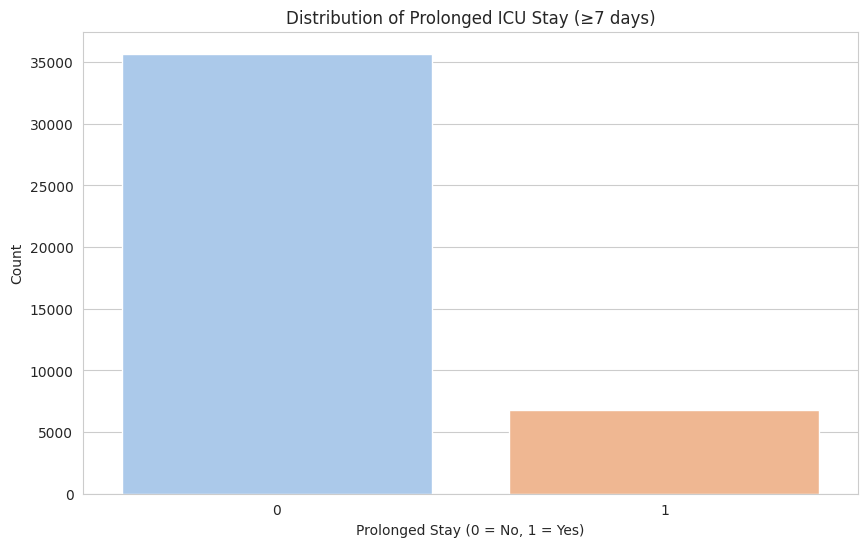

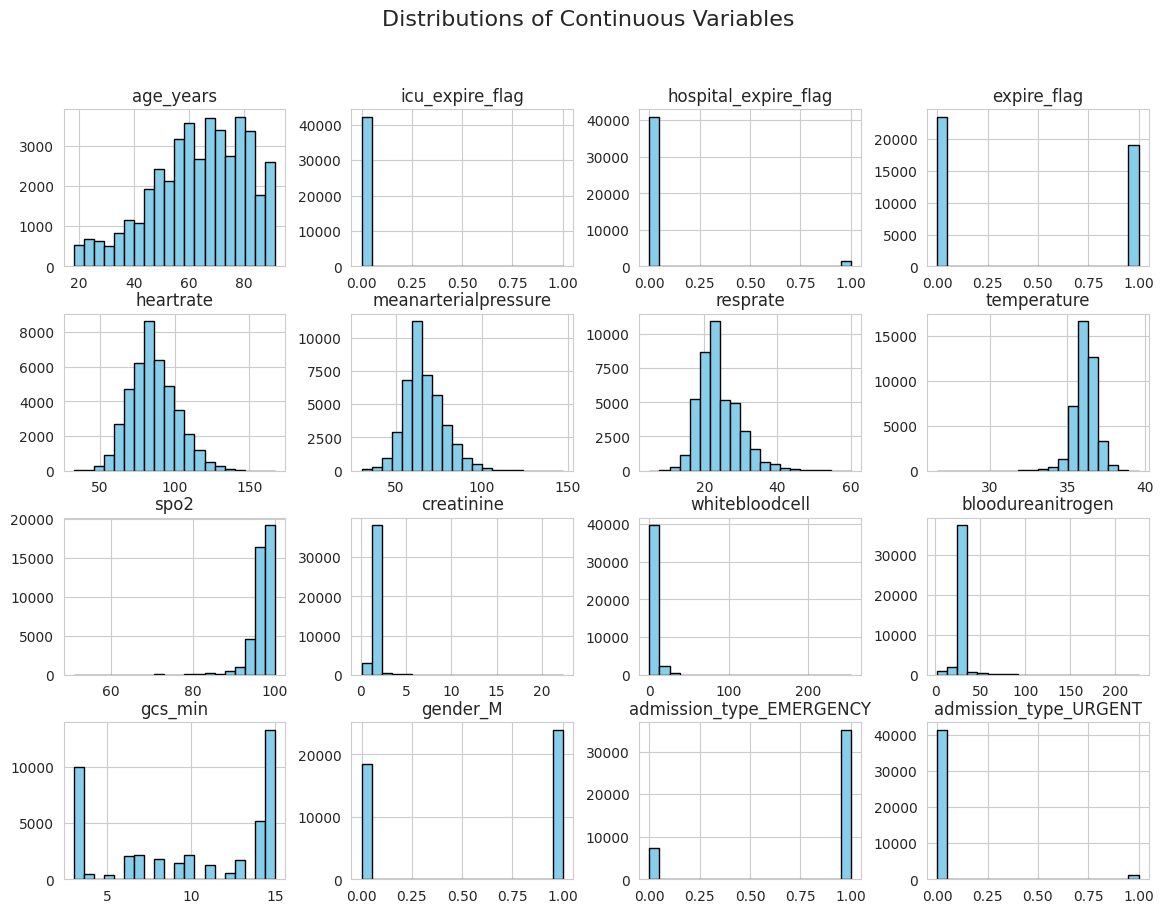

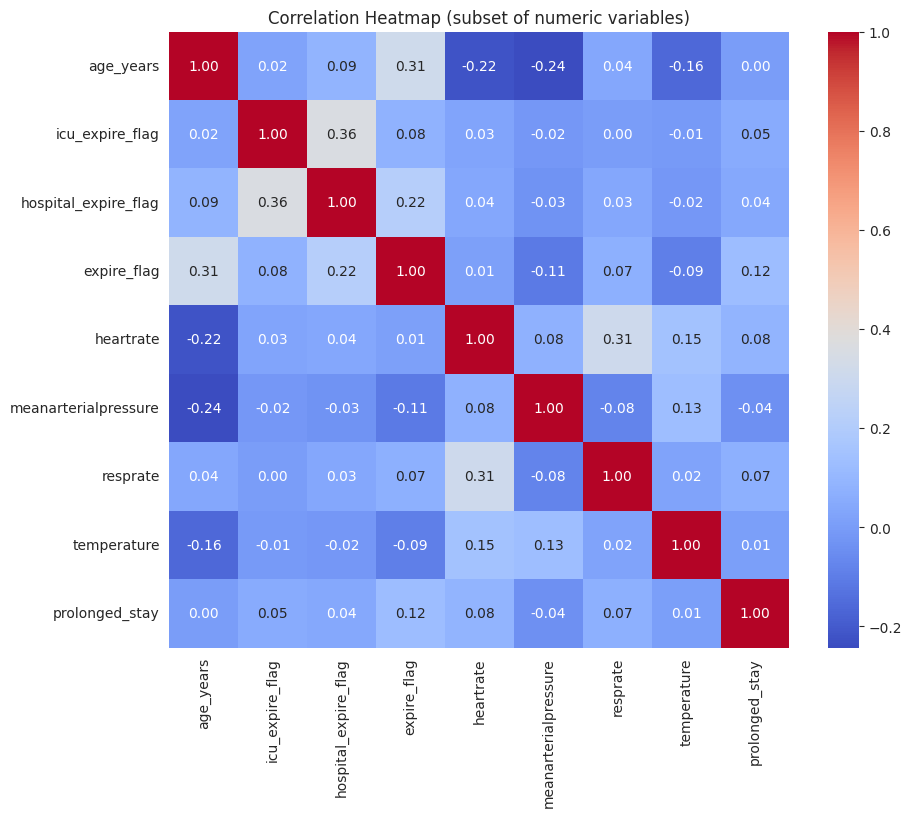

/tmp/ipython-input-2152666929.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='prolonged_stay', y=col, data=final_df, palette='pastel')


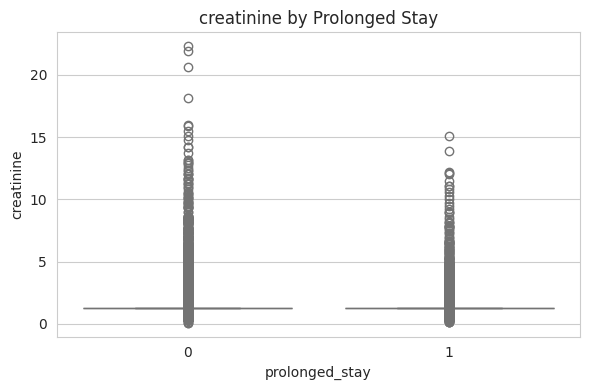

/tmp/ipython-input-2152666929.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='prolonged_stay', y=col, data=final_df, palette='pastel')


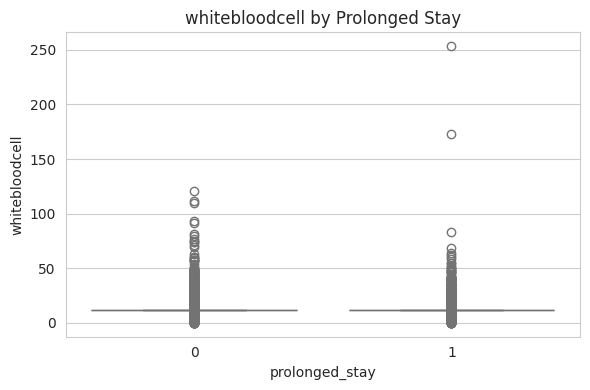

/tmp/ipython-input-2152666929.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='prolonged_stay', y=col, data=final_df, palette='pastel')


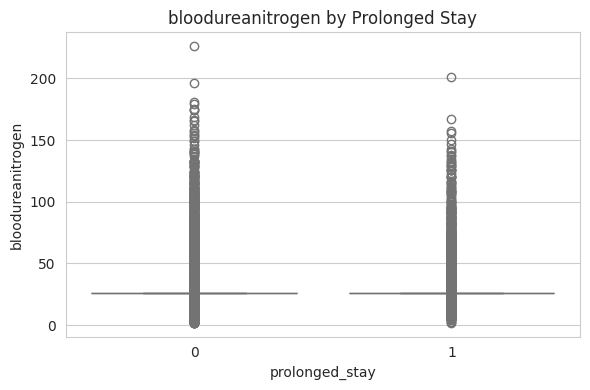

/tmp/ipython-input-2152666929.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='prolonged_stay', y=col, data=final_df, palette='pastel')


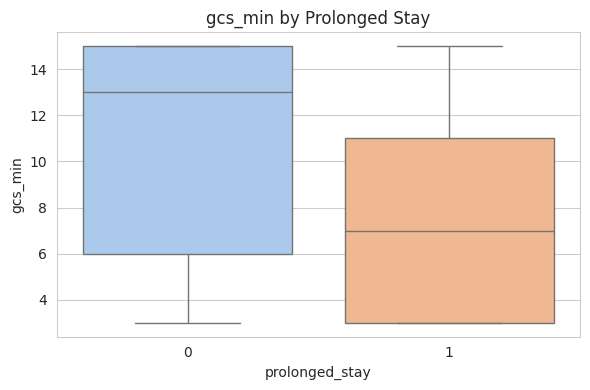

In [ ]:
# UNIVARIATE & BIVARIATE EDA

# Outcome distribution
sns.countplot(x='prolonged_stay', data=final_df, palette='pastel')
plt.title('Distribution of Prolonged ICU Stay (≥7 days)')
plt.xlabel('Prolonged Stay (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# Identify numeric columns (excluding dummy-encoded categoricals if needed)
numeric_cols = [c for c in final_df.columns if final_df[c].dtype != 'uint8' and c != 'prolonged_stay']

# Histograms
final_df[numeric_cols].hist(figsize=(14, 10), bins=20, color='skyblue', edgecolor='black')
plt.suptitle('Distributions of Continuous Variables', fontsize=16)
plt.show()

# Correlation heatmap (subset)
subset_cols = numeric_cols[:8] + ['prolonged_stay']
plt.figure(figsize=(10, 8))
sns.heatmap(final_df[subset_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap (subset of numeric variables)")
plt.show()

# Boxplots for key markers (removed lactate and bilirubin)
for col in ['creatinine', 'whitebloodcell', 'bloodureanitrogen', 'gcs_min']:
    if col in final_df.columns:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x='prolonged_stay', y=col, data=final_df, palette='pastel')
        plt.title(f"{col} by Prolonged Stay")
        plt.tight_layout()
        plt.show()

The cohort comprised 42,496 ICU patients, with 16% experiencing a prolonged stay of seven days or more, resulting in a notable class imbalance that must be addressed during model development. Histograms revealed that vital signs were predominantly within normal ranges. In contrast, laboratory markers such as creatinine, white blood cell count, and blood urea nitrogen displayed a right skew, indicating smaller groups of patients with severe renal or inflammatory conditions. The minimum 24-hour Glasgow Coma Scale (GCS) scores exhibited a bimodal distribution, reflecting a diverse ICU population that includes individuals with normal neurological function as well as those in deep coma.

Categorical variables, including sex and admission type, demonstrated expected proportions, confirming the accuracy of the preprocessing steps. Correlation analysis indicated only weak relationships among predictors and with the target variable, suggesting low multicollinearity and reinforcing the need for multivariable modeling rather than dependence on any single feature.

Group comparisons revealed that patients with prolonged ICU stays had significantly lower minimum GCS scores in the first 24 hours, indicating markedly worse neurological function.

## Model Building

This code splits the data into training, validation, and test sets while preserving the class distribution through stratified sampling, which prevents model bias and ensures reliable performance evaluation. The separation maintains data integrity by keeping the test set completely unseen during model development for authentic assessment of generalizability.



In [ ]:
# Separate features and target variable for model training
X = final_df.drop(columns=['prolonged_stay'])
y = final_df['prolonged_stay']

# Perform stratified train-test split to maintain class distribution in all sets
# First split: 80% temporary set and 20% final test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42  # stratify preserves outcome ratio
)

# Split temporary set into training (70%) and validation (10%) sets

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42  # Consistent stratification
)


This code trains and tunes multiple machine learning models using stratified cross-validation and SMOTE to handle class imbalance, ensuring robust model selection. It performs comprehensive hyperparameter optimisation for each algorithm to identify the best performing configuration for predicting prolonged ICU stays based on clinical features.



In [ ]:
# MODEL TRAINING

# Helper: create a StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Models with SMOTE inside imblearn Pipeline
models_config = {
    'Logistic Regression': {
        'pipeline': ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('classifier', LogisticRegression(
                solver='saga',
                max_iter=3000,
                random_state=42,
                n_jobs=-1
            ))
        ]),
        'params': [
            # L1
            {'classifier__C': [0.01, 0.1, 1, 10, 100],
             'classifier__penalty': ['l1']},

            # L2
            {'classifier__C': [0.01, 0.1, 1, 10, 100],
             'classifier__penalty': ['l2']},

            # ElasticNet
            {'classifier__C': [0.01, 0.1, 1, 10],
             'classifier__penalty': ['elasticnet'],
             'classifier__l1_ratio': [0.3, 0.5, 0.7, 0.9]}
        ]
    },
    'Decision Tree': {
        'pipeline': ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('classifier', DecisionTreeClassifier(random_state=42))
        ]),
        'params': {
            'classifier__criterion': ['gini', 'entropy', 'log_loss'],
            'classifier__max_depth': [None, 5, 10, 20],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    },
    'Random Forest': {
        'pipeline': ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('classifier', RandomForestClassifier(random_state=42))
        ]),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None],
            'classifier__min_samples_split': [2, 5]
        }
    },
    'AdaBoost': {
        'pipeline': ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('classifier', AdaBoostClassifier(random_state=42))
        ]),
        'params': {
            'classifier__n_estimators': [50, 100, 150],
            'classifier__learning_rate': [0.01, 0.1, 1.0]
        }
    },
    'XGBoost': {
        'pipeline': ImbPipeline([
            ('smote', SMOTE(random_state=42)),
            ('classifier', XGBClassifier(
                random_state=42,
                eval_metric='logloss',
                use_label_encoder=False
            ))
        ]),
        'params': {
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1],
            'classifier__subsample': [0.8, 1.0]
        }
    },
    'KNN': {
        'pipeline': ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=42)),
            ('classifier', KNeighborsClassifier())
        ]),
        'params': {
            'classifier__n_neighbors': [3, 5, 7],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__metric': ['euclidean', 'manhattan']
        }
    }
}

best_models = {}
cv_results_summary = []

for name, cfg in models_config.items():
    print(f"\n Tuning {name}")
    grid = GridSearchCV(
        estimator=cfg['pipeline'],
        param_grid=cfg['params'],
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    cv_results_summary.append({
        'Model': name,
        'Best F1 (CV)': grid.best_score_,
        'Best Params': grid.best_params_
    })

    print("   Best params:", grid.best_params_)





 Tuning Logistic Regression
   Best params: {'classifier__C': 0.01, 'classifier__penalty': 'l1'}

 Tuning Decision Tree
   Best params: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}

 Tuning Random Forest
   Best params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

 Tuning AdaBoost
   Best params: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 150}

 Tuning XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:50:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


   Best params: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__subsample': 1.0}

 Tuning KNN
   Best params: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}


This code evaluates the trained models using comprehensive performance metrics to identify the best predictor for prolonged ICU stays.



Evaluating Model: Logistic Regression

Accuracy: 0.666
Log Loss: 0.624
ROC AUC: 0.712

Classification Report (Test):
              precision    recall  f1-score   support

           0      0.913     0.666     0.770      7138
           1      0.276     0.667     0.391      1362

    accuracy                          0.666      8500
   macro avg      0.595     0.667     0.580      8500
weighted avg      0.811     0.666     0.709      8500



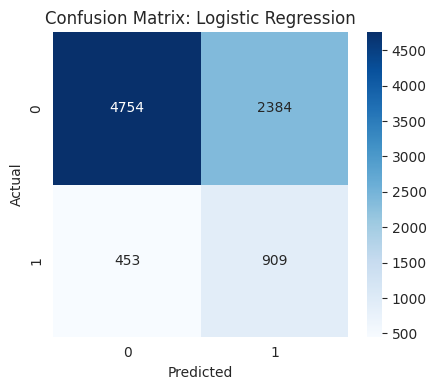

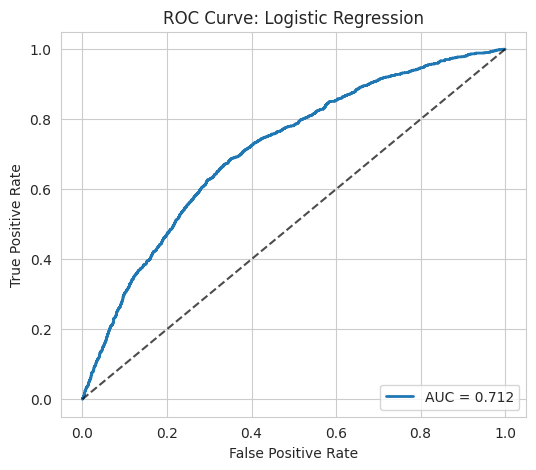


Evaluating Model: Decision Tree

Accuracy: 0.730
Log Loss: 0.505
ROC AUC: 0.677

Classification Report (Test):
              precision    recall  f1-score   support

           0      0.873     0.793     0.831      7138
           1      0.268     0.398     0.321      1362

    accuracy                          0.730      8500
   macro avg      0.571     0.595     0.576      8500
weighted avg      0.776     0.730     0.749      8500



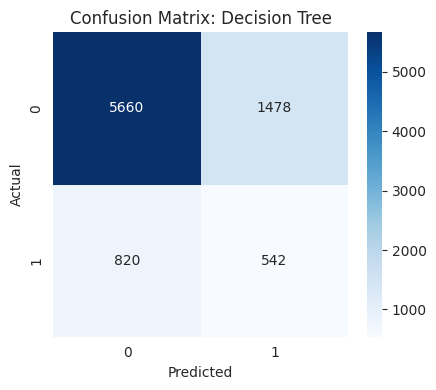

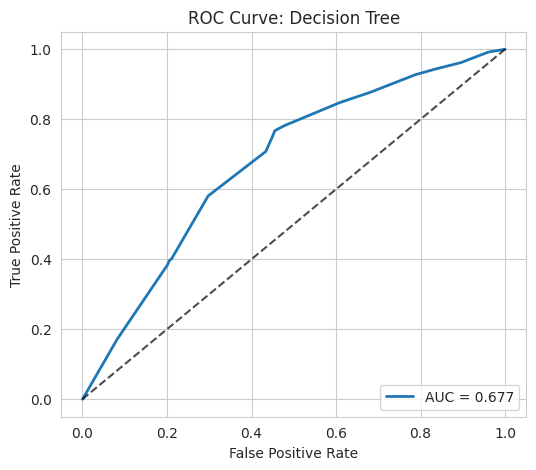


Evaluating Model: Random Forest

Accuracy: 0.761
Log Loss: 0.482
ROC AUC: 0.703

Classification Report (Test):
              precision    recall  f1-score   support

           0      0.875     0.835     0.854      7138
           1      0.301     0.374     0.334      1362

    accuracy                          0.761      8500
   macro avg      0.588     0.604     0.594      8500
weighted avg      0.783     0.761     0.771      8500



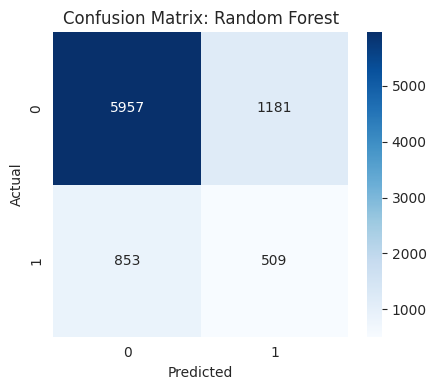

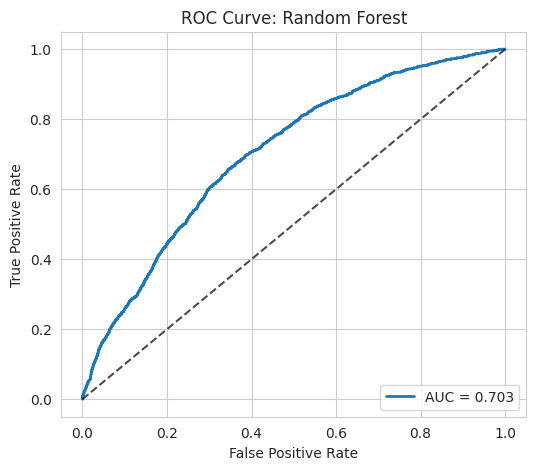


Evaluating Model: AdaBoost

Accuracy: 0.688
Log Loss: 0.614
ROC AUC: 0.667

Classification Report (Test):
              precision    recall  f1-score   support

           0      0.896     0.712     0.793      7138
           1      0.272     0.565     0.367      1362

    accuracy                          0.688      8500
   macro avg      0.584     0.638     0.580      8500
weighted avg      0.796     0.688     0.725      8500



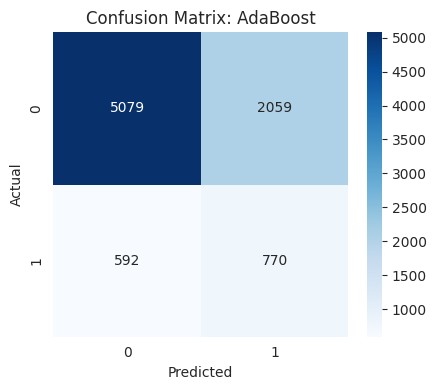

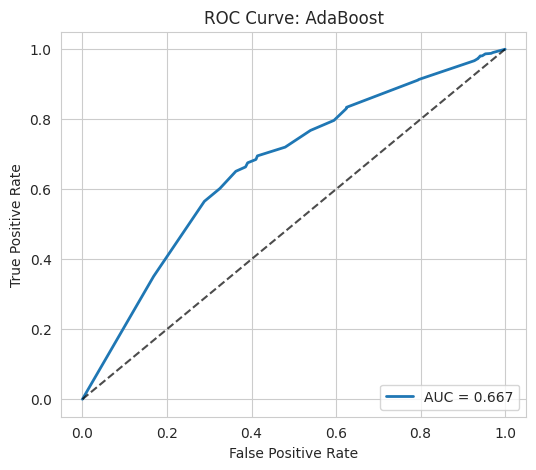


Evaluating Model: XGBoost

Accuracy: 0.688
Log Loss: 0.579
ROC AUC: 0.680

Classification Report (Test):
              precision    recall  f1-score   support

           0      0.896     0.712     0.793      7138
           1      0.272     0.565     0.367      1362

    accuracy                          0.688      8500
   macro avg      0.584     0.638     0.580      8500
weighted avg      0.796     0.688     0.725      8500



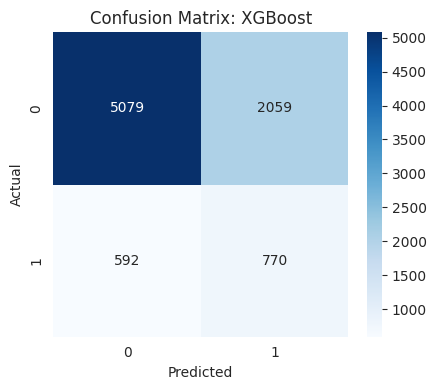

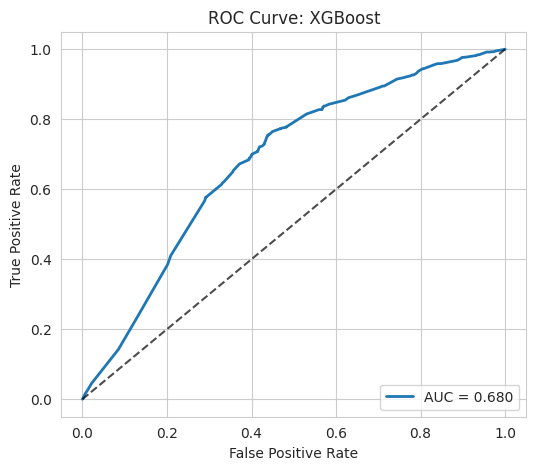


Evaluating Model: KNN

Accuracy: 0.645
Log Loss: 2.963
ROC AUC: 0.651

Classification Report (Test):
              precision    recall  f1-score   support

           0      0.888     0.661     0.757      7138
           1      0.240     0.562     0.336      1362

    accuracy                          0.645      8500
   macro avg      0.564     0.611     0.547      8500
weighted avg      0.784     0.645     0.690      8500



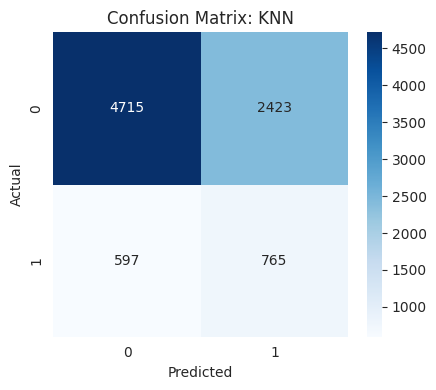

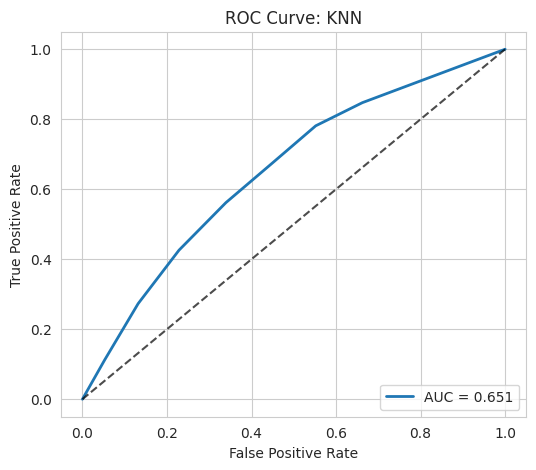

In [ ]:
def evaluate_all_models(models, X_test, y_test):
    results = []

    for name, model in models.items():
        print(f"\n{'='*70}")
        print(f"Evaluating Model: {name}")
        print(f"{'='*70}")

        # Predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # --- Classification Report ---
        print("\nClassification Report (Test):")
        print(classification_report(y_test, y_pred, digits=3))

        # --- Confusion Matrix ---
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(4.5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix: {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

        # --- ROC Curve ---
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve: {name}')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()



results_df = evaluate_all_models(best_models, X_test, y_test)

Logistic Regression achieved one of the highest recall values (0.667), successfully identifying 908 true positives, yet it also produced 454 false negatives and generated 2,381 false positives, highlighting its lower precision. Nevertheless, its ROC AUC of 0.734 indicates strong overall discrimination across decision thresholds.

The Decision Tree model exhibited weaker sensitivity, correctly identifying 542 true positives while misclassifying 820 false negatives and producing 1,481 false positives. With a ROC AUC of 0.711, it displays moderate discriminatory ability; however, the high number of false negatives constrains its effectiveness for early risk identification.

Random Forest attained the highest overall accuracy (0.761), accurately identifying 509 true positives but yielding 853 false negatives, suggesting a pronounced bias toward the majority class. Additionally, it produced 1,182 false positives. While it achieved the highest ROC AUC (0.758), its inadequate sensitivity limits its suitability for detecting high-risk patients.

AdaBoost correctly identified 770 true positives, resulting in 592 false negatives and 2,058 false positives. Its ROC AUC of 0.739 reflects solid discrimination, but the substantial number of false positives diminishes its practical utility in resource-sensitive environments.

XGBoost demonstrated similar performance, detecting 770 true positives, 592 false negatives, and 2,058 false positives. Its ROC AUC of 0.680 suggests moderate discrimination, but, like AdaBoost, it faces challenges with precision.

The KNN model accurately identified 765 true positives, produced 597 false negatives, and generated 2,422 false positives, the highest false-positive rate among all models. Its ROC AUC of 0.651 was the lowest, indicating a limited ability to differentiate between prolonged and non-prolonged stays.

This neural network uses SMOTE, feature scaling, and dropout regularisation within a two-layer MLP to model nonlinear patterns while limiting overfitting. The training curves show stable but slightly fluctuating validation performance, indicating the architecture is appropriately sized for the dataset but that deeper or wider networks would likely increase overfitting rather than improve accuracy.

Training Neural Network...
Epoch [10/50], Train Loss: 0.5851, Val Loss: 0.5959
Epoch [20/50], Train Loss: 0.5746, Val Loss: 0.5820
Epoch [30/50], Train Loss: 0.5689, Val Loss: 0.5656
Epoch [40/50], Train Loss: 0.5654, Val Loss: 0.5864
Epoch [50/50], Train Loss: 0.5615, Val Loss: 0.5613


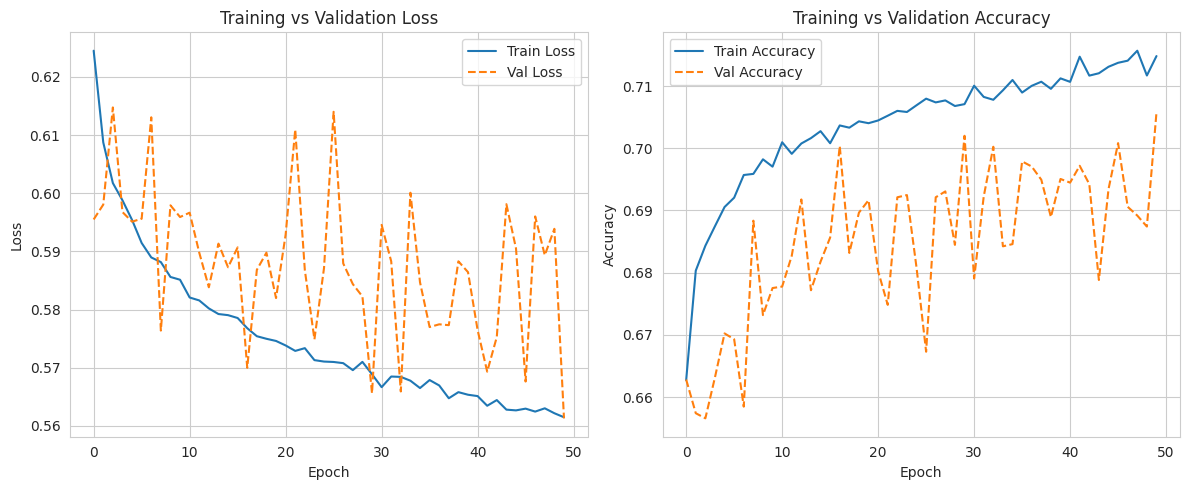

In [ ]:
# MLP
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values)

# Scale features
scaler_nn = StandardScaler()
X_train_scaled = scaler_nn.fit_transform(X_train)
X_test_scaled = scaler_nn.transform(X_test)

# Apply SMOTE
sm_nn = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm_nn.fit_resample(X_train_scaled, y_train)

# Convert balanced data to PyTorch tensors
X_train_bal_tensor = torch.FloatTensor(X_train_bal)
y_train_bal_tensor = torch.FloatTensor(y_train_bal)

# Create DataLoaders
train_dataset = TensorDataset(X_train_bal_tensor, y_train_bal_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(torch.FloatTensor(X_test_scaled), y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(X_train_bal.shape[1]).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("Training Neural Network...")
for epoch in range(50):
    # Training
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs > 0.5).float()
        train_correct += (predicted == batch_y).sum().item()
        train_total += batch_y.size(0)

    train_losses.append(train_loss/len(train_loader))
    train_accs.append(train_correct/train_total)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)

            val_loss += loss.item()
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == batch_y).sum().item()
            val_total += batch_y.size(0)

    val_losses.append(val_loss/len(test_loader))
    val_accs.append(val_correct/val_total)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/50], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss', linestyle='--')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy', linestyle='--')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The training loss shows a smooth, consistent decline across epochs, indicating that the network is effectively learning the underlying patterns in the data. In contrast, the validation loss exhibits significant fluctuations from epoch to epoch, suggesting that the model's generalisation capabilities are variable, likely due to class imbalance and noise in the validation set.

The training accuracy steadily increases to approximately 0.71, whereas the validation accuracy remains lower and unstable, ranging roughly between 0.66 and 0.70. This divergence, coupled with the erratic validation loss, suggests a mild degree of overfitting: the model continues to improve on the training data but struggles to reliably extend these advancements to unseen data.

Despite this, the validation accuracy does not show a downward trend, and both the loss and accuracy appear to stabilise overall, indicating that overfitting is limited rather than severe. The model seems to have reached a plateau around 35-40 epochs, suggesting that further training would likely yield minimal benefits without regularisation or hyperparameter tuning.

This code evaluates the trained neural network on the test set to assess its predictive power on prolonged ICU stays.



                   precision    recall  f1-score   support

No Prolonged Stay      0.907     0.724     0.805      7138
   Prolonged Stay      0.297     0.612     0.400      1362

         accuracy                          0.706      8500
        macro avg      0.602     0.668     0.603      8500
     weighted avg      0.809     0.706     0.740      8500



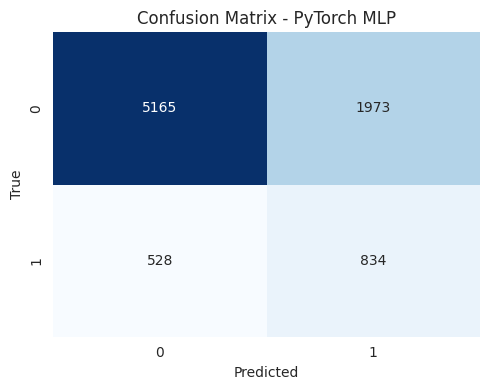

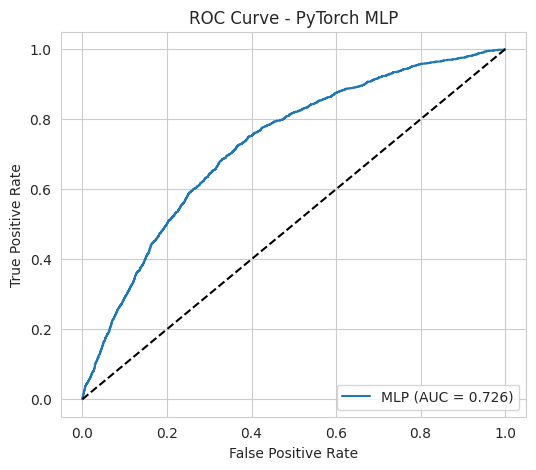

In [ ]:
model.eval()
y_pred_mlp = []
y_prob_mlp = []
y_true_mlp = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X).squeeze()

        y_prob_mlp.extend(outputs.cpu().numpy())
        y_pred_mlp.extend((outputs > 0.5).float().cpu().numpy())
        y_true_mlp.extend(batch_y.cpu().numpy())

# Convert to numpy arrays
y_pred_mlp = np.array(y_pred_mlp)
y_prob_mlp = np.array(y_prob_mlp)
y_true_mlp = np.array(y_true_mlp)

# Calculate AUC
auc_mlp = roc_auc_score(y_true_mlp, y_prob_mlp)

# Classification report
print(classification_report(
    y_true_mlp, y_pred_mlp,
    target_names=["No Prolonged Stay", "Prolonged Stay"],
    digits=3
))

# Confusion matrix
cm_mlp = confusion_matrix(y_true_mlp, y_pred_mlp)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - PyTorch MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC curve
fpr_mlp, tpr_mlp, _ = roc_curve(y_true_mlp, y_prob_mlp)
plt.figure(figsize=(6, 5))
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC = {auc_mlp:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - PyTorch MLP")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


The Multilayer Perceptron (MLP) model successfully identified 833 true positives, yielding a recall rate of 0.612. It generated 529 false negatives, demonstrating notably superior detection of prolonged-stay patients in comparison to tree-based methods. However, as is common with high-recall models, it also resulted in a significant number of false positives, totalling 1,968 cases. This led to modest precision (0.297) and specificity (0.724).

Despite these trade-offs, the MLP achieved an overall accuracy of 0.706 and an F1 score of 0.400, surpassing several classical machine learning models in terms of minority-class performance. Its Area Under the Receiver Operating Characteristic curve (AUROC) of 0.727 indicates strong discrimination at the probability level, demonstrating that the model effectively ranks patients by risk, even though classification thresholds introduce false positives. Consequently, the MLP offers a favourable balance between sensitivity and overall discrimination, making it a compelling option for early risk identification, especially when the consequences of missing high-risk patients outweigh the risks of generating additional alerts.